# Classical Supervised Learning

Supervised machine learning is when we use a dataset **with known structure and/or features** to teach an algorithm how to approximate a function

$$ y = f(x) $$

between the data $x$ and the known outcome $y$. Classical machine learning is the machine learning algorithms that are not deep neural networks. Thus classical supervised learning is achieved by approximating the function $f$ using alternative methods to deep neural networks.

In this exercise notebook we will look at different datasets, their structure and how to classify the data in the datasets. On top of this we will see how shallow neural networks can be used as **universal function approximators**.

We will start by classifying the same dataset using different classification methods and how this affects the accuracy and the placement of the decision boundary in the dataset.

In [1]:
%matplotlib notebook
%config InlineBackend.figure_format = "retina"

import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
import numpy as np
from matplotlib.colors import ListedColormap
from sklearn.linear_model import Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
import sklearn.gaussian_process.kernels as kernels
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, SVR
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from scipy import special
from IPython.core.display import display,HTML
display(HTML("<style>.container{ width: 100% !important;} <\style>"))
import warnings
warnings.filterwarnings("ignore",category=FutureWarning,append=True)

## Aside: plotting code

I have provided a plotting code to plot the results of a classifier and the decision boundaries. This is provided as an easy to use function as I didn't see the need for anyone else to have to struggle with `matplotlib` to make these plots.

In [2]:
def class_plot(data,targets,feature_names,classifier,rang=0.25):
    '''
    A function to make the boundary contour plots.
    
    Parameters
    ----------
    data : numpy.ndarray
        The feature data.
    targets : numpy.ndarray
        The labels of the data samples.
    feature_names : list
        A list of the names of the features to be compared.
    classifier : various
        The class instance for the classifier being used after training.
    rang : float
        Defines the range of the x-axis and y-axis.
    '''
    
    x_min, x_max = data[:,0].min() - rang, data[:,0].max() + rang
    y_min, y_max = data[:,1].min() - rang, data[:,1].max() + rang
    
    xx, yy = np.meshgrid(np.arange(x_min,x_max,0.02),np.arange(y_min,y_max,0.02))
    
    if hasattr(classifier,"decision_function"):
        Z = classifier.decision_function(np.c_[xx.ravel(),yy.ravel()]).reshape(xx.shape)
    else:
        Z = classifier.predict_proba(np.c_[xx.ravel(),yy.ravel()])[:,1].reshape(xx.shape)

    cm = ListedColormap(["#FF0000","#0000FF"])

    plt.figure()
    plt.contourf(xx,yy,Z,cmap="RdBu",alpha=0.8)
    plt.scatter(data[:,0],data[:,1],c=targets,cmap=cm)
    plt.ylabel(feature_names[1])
    plt.xlabel(feature_names[0])

## Classification Dataset

Next we must load the dataset. The data is saved in ```.npz``` format. This is a data format native to ```numpy``` and works to save multiple ```numpy``` arrays to disk without losing any information. For more information check out the [`scipy` documentation](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.lib.format.html#module-numpy.lib.format). ```.npz``` is essentially a ```.zip``` of ```numpy``` arrays. Loading a ```.npz``` file returns a ```dict```-like object where the arrays have the keys corresponding to the names assigned when saving the file. e.g.

```python
>>> import numpy as np
>>> a = np.array([[1,2],[3,4]])
>>> np.savez_compressed("a.npz",data=a)
>>> f = np.load("a.npz")
>>> f["data"] == a
array([[True, True],
       [True, True]])
```

In the example above, we use the function ```savez_compressed``` to save the data which creates a compressed ```.npz``` file but the function ```savez``` to create an uncompressed ```.npz``` file also exists (but when loading the data will make your code slower. ```.npz``` files preserve the structure of the arrays so there is no need to worry about doing any data manipulations when working with these files.

In [3]:
data = np.load("data.npz")

In [5]:
list(data.keys()) #this tells you what is in the dataset

['features', 'labels']

## Classification Method #1: The Perceptron

The perceptron is the simplest machine learning algorithm as it consists of a linear transformation followed by a non-linear step function to calculate its output. This is essentially one "neuron" of a layer of a neural network. This can be trained for only linear tasks and our dataset is a non-linear binary classification set which can be reflected in the perfomance.

1. Create a perceptron instance.
2. Next, fit this to the data and check the accuracy.
3. Lastly, plot your reduced data showing the decision boundaries using the plotting code provided.

**Feel free to change the tolerance level in the perceptron class instance to try to improve convergence (or make it worse).**
**Make sure to always choose** `random_state` **to be the same number when creating the class instance otherwise it will train differently every time.**

In [6]:
X, y = data["features"], data["labels"]

In [7]:
p = Perceptron()
p.fit(X,y)

Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
      fit_intercept=True, max_iter=None, n_iter=None, n_iter_no_change=5,
      n_jobs=None, penalty=None, random_state=0, shuffle=True, tol=None,
      validation_fraction=0.1, verbose=0, warm_start=False)

In [8]:
p.score(X,y)

0.8466666666666667

<IPython.core.display.Javascript object>


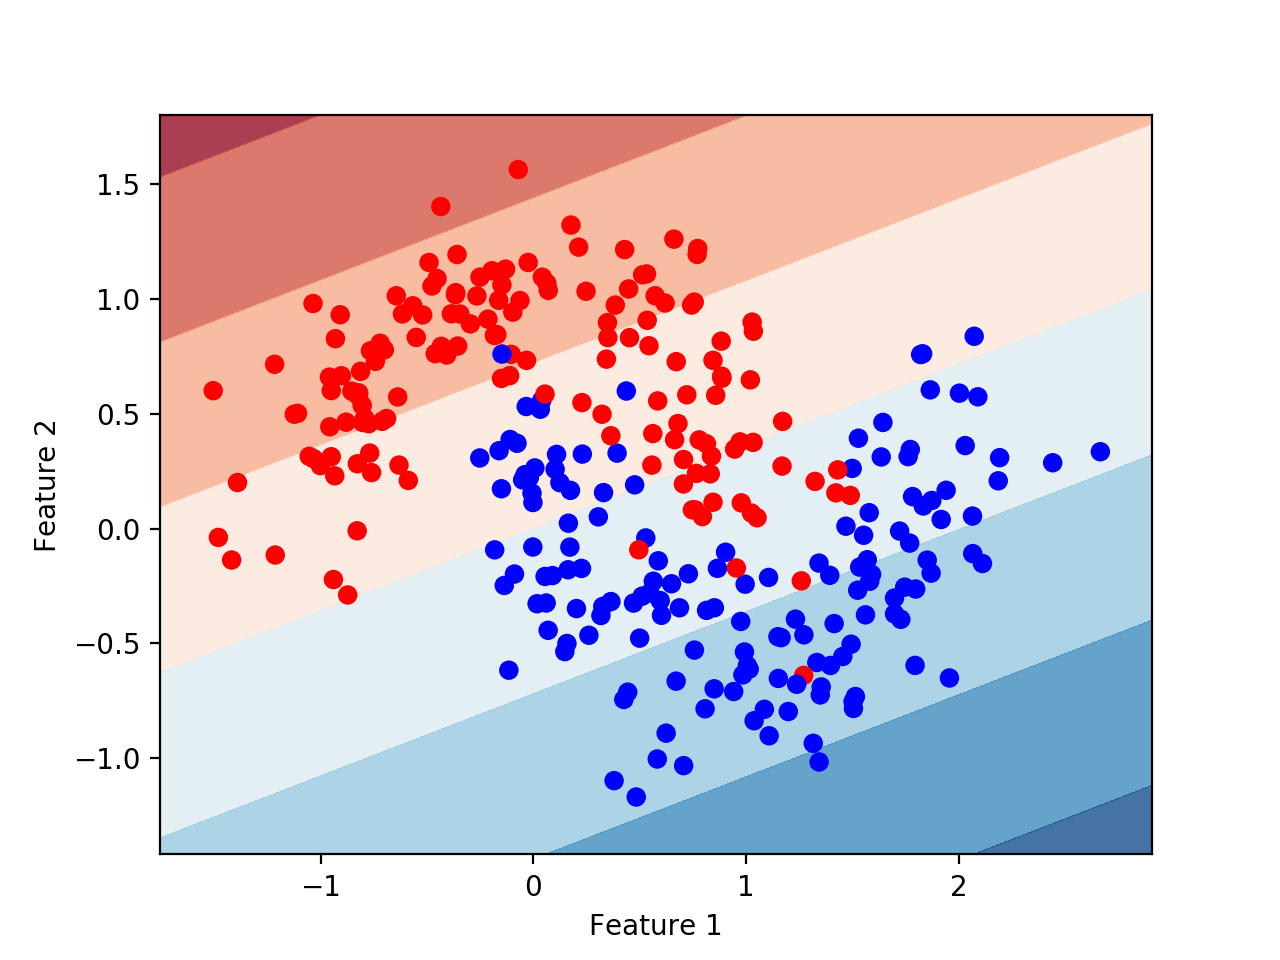

In [9]:
class_plot(X,y,["Feature 1","Feature 2"],p)

## Classification Method #2: K-Nearest Neighbours

K-nearest neighbours is a instance-based classifier and rather than learning a general model, this method learns information about the training data (i.e. where they lie in the 2D plane) to choose where to put the data it has not seen before. Classification in this case is performed by a majority vote, the distance from a point to the k nearest neighbours is calculated and the minimal distance defines what class the point belongs to.

The process is the same as that above.

**Try different numbers of nearest neighbours to see which gives you the best accuracy.**

In [10]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X,y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='uniform')

In [11]:
knn.score(X,y)

0.9733333333333334

<IPython.core.display.Javascript object>


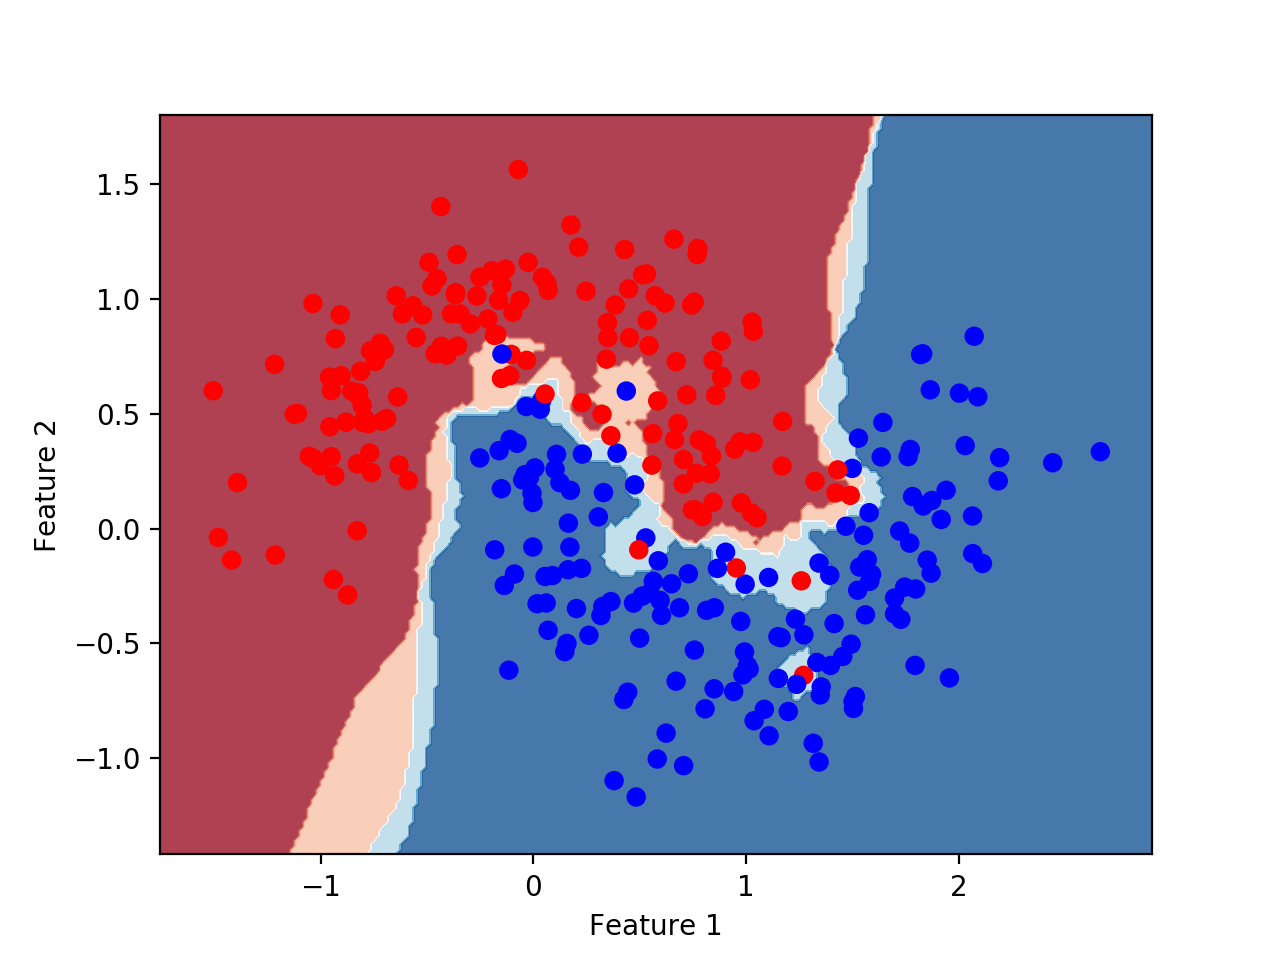

In [12]:
class_plot(X,y,["Feature 1","Feature 2"],knn)

## Classification Method #3: Gaussian Processes

A Gaussian process is one in which each of the classes in the dataset is assumed to be normally distributed i.e. drawn from a multivariate normal distribution. The distribution of the entire process is then the joint distribution of the features and is thus a continuous distribution in the space we are working.

We start from the assumption that each class is drawn from a normal with zero mean and a covariance matrix that we would like to learn to represent the data. This covariance matrix is often referred to as the kernel of the Gaussian process and is something that can be changed to yield different results. Starting from a Gaussian and calculating the covariance between the points in the classes allows the distribution of each class to be jointly updated until convergence.

**For the dataset provided, try different covariance matrices to see which converges the best.**

In [13]:
kernel = kernels.RBF()
gp = GaussianProcessClassifier(kernel=kernel)
gp.fit(X,y)

GaussianProcessClassifier(copy_X_train=True, kernel=RBF(length_scale=1),
             max_iter_predict=100, multi_class='one_vs_rest', n_jobs=None,
             n_restarts_optimizer=0, optimizer='fmin_l_bfgs_b',
             random_state=None, warm_start=False)

In [14]:
gp.score(X,y)

0.9666666666666667

<IPython.core.display.Javascript object>


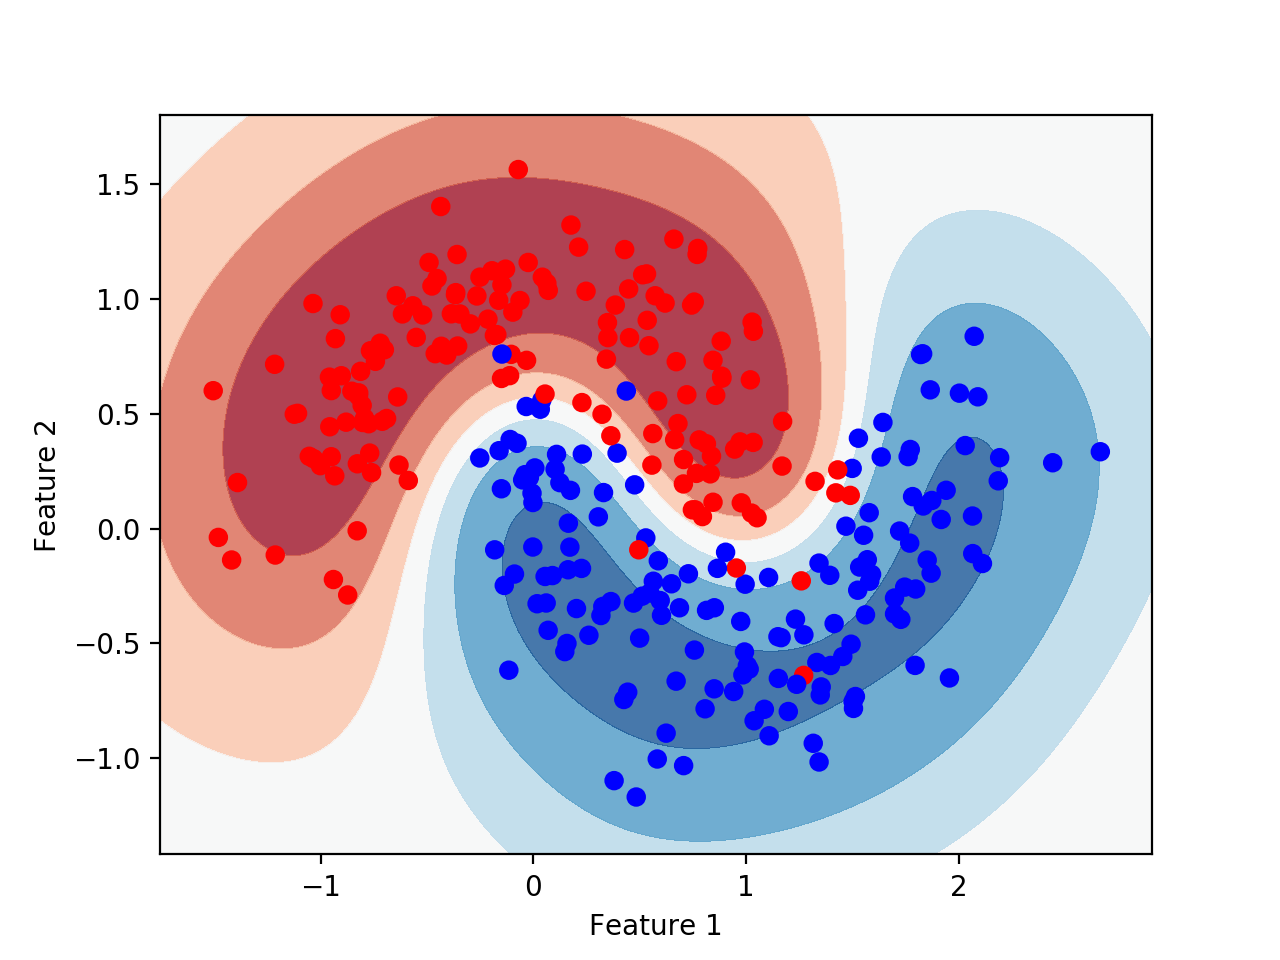

In [15]:
class_plot(X,y,["Feature 1","Feature 2"],gp)

## Classification Method #4: Support Vector Machine (SVM)

The last classification technique we will employ is the support vector machine (SVM). Support vector machines find a non-linear transformation in the dimension one higher than the dimension of the data to find a hyperplane which makes the data linearly separable. The "support vectors" are the points in the plane closest to the boundary of this hyperplane to help refine the position of it.

**Try different kernels to see which transformation yields the best solution.**

In [16]:
svm = SVC()
svm.fit(X,y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [17]:
svm.score(X,y)

0.9566666666666667

<IPython.core.display.Javascript object>


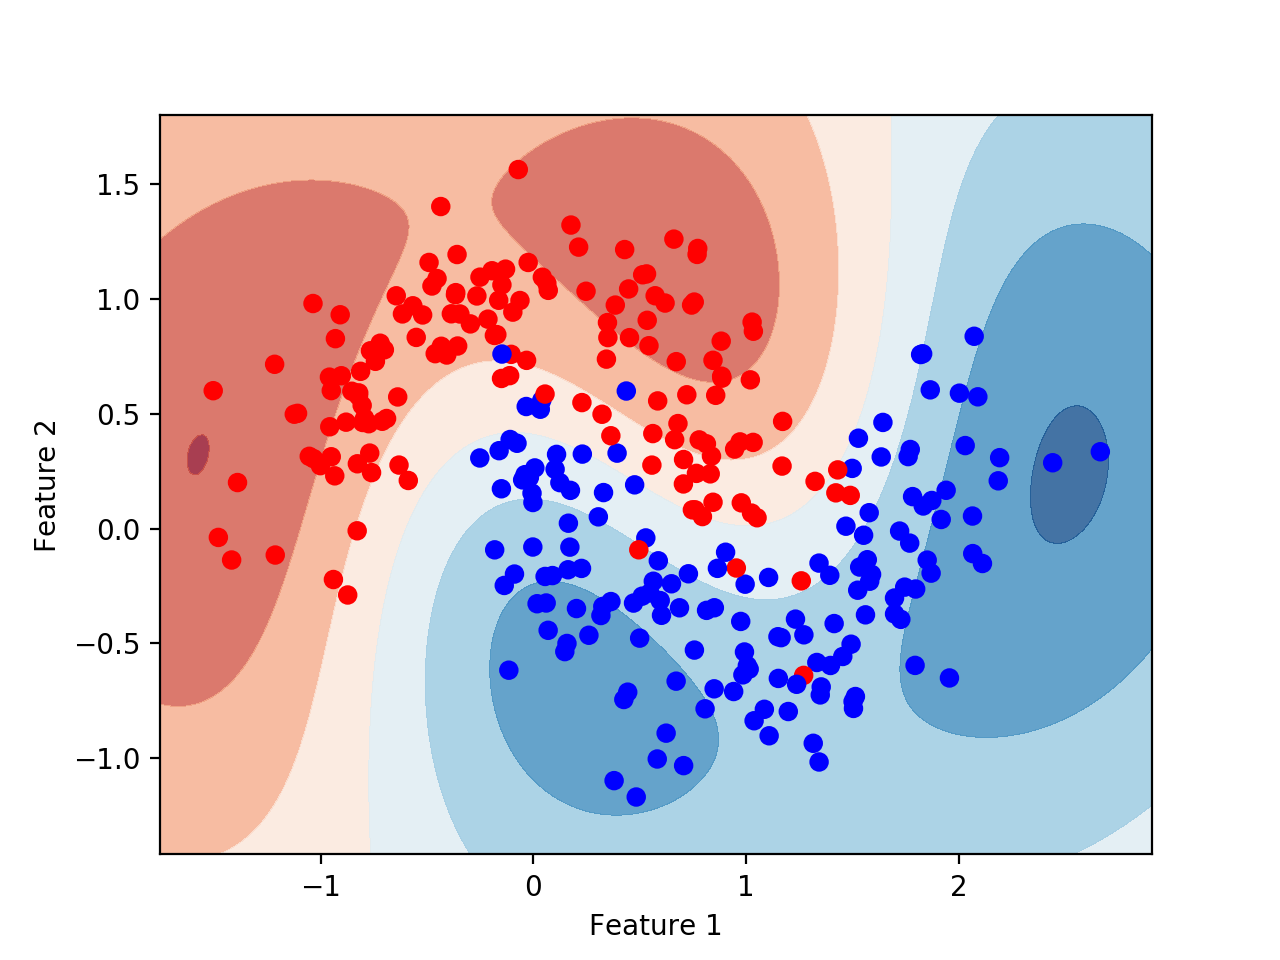

In [18]:
class_plot(X,y,["Feature 1","Feature 2"],svm)

## Function Approximation using SVMs and Neural Networks

The follow is an exercise on function approximating with support vector machines (SVMs) and neural networks. The neural network here has one layer between the input and output and is well-versed at function approximation. The dataset we use here is `voigt.npz`. This is the Voigt H function for damping factor a = 1, i.e.,

$$ H (a, v) = \frac{a}{\pi} \int_{0}^{\infty} \frac{e^{- (v^{\prime})^{2}}}{a^{2} + (v - v^{\prime})^{2}} dv^{\prime} $$

The profile made for a range in v and a = 1 then has random Gaussian noise applied to it and we want to see how well we can approximate this, first using an SVM and second using a shallow neural network. After learning the function try plotting the true line profile (also given in the data file) to see how well your fit done.

In [19]:
voigt = np.load("voigt.npz")

In [21]:
list(voigt.keys())

['inputs', 'profile', 'true_profile']

In [22]:
X, y = voigt["inputs"], voigt["profile"]

In [23]:
svm = SVR(tol=1e-5)
svm.fit(X.reshape(-1,1),y)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=1e-05, verbose=False)

In [24]:
y_rbf = svm.predict(X.reshape(-1,1))

<IPython.core.display.Javascript object>


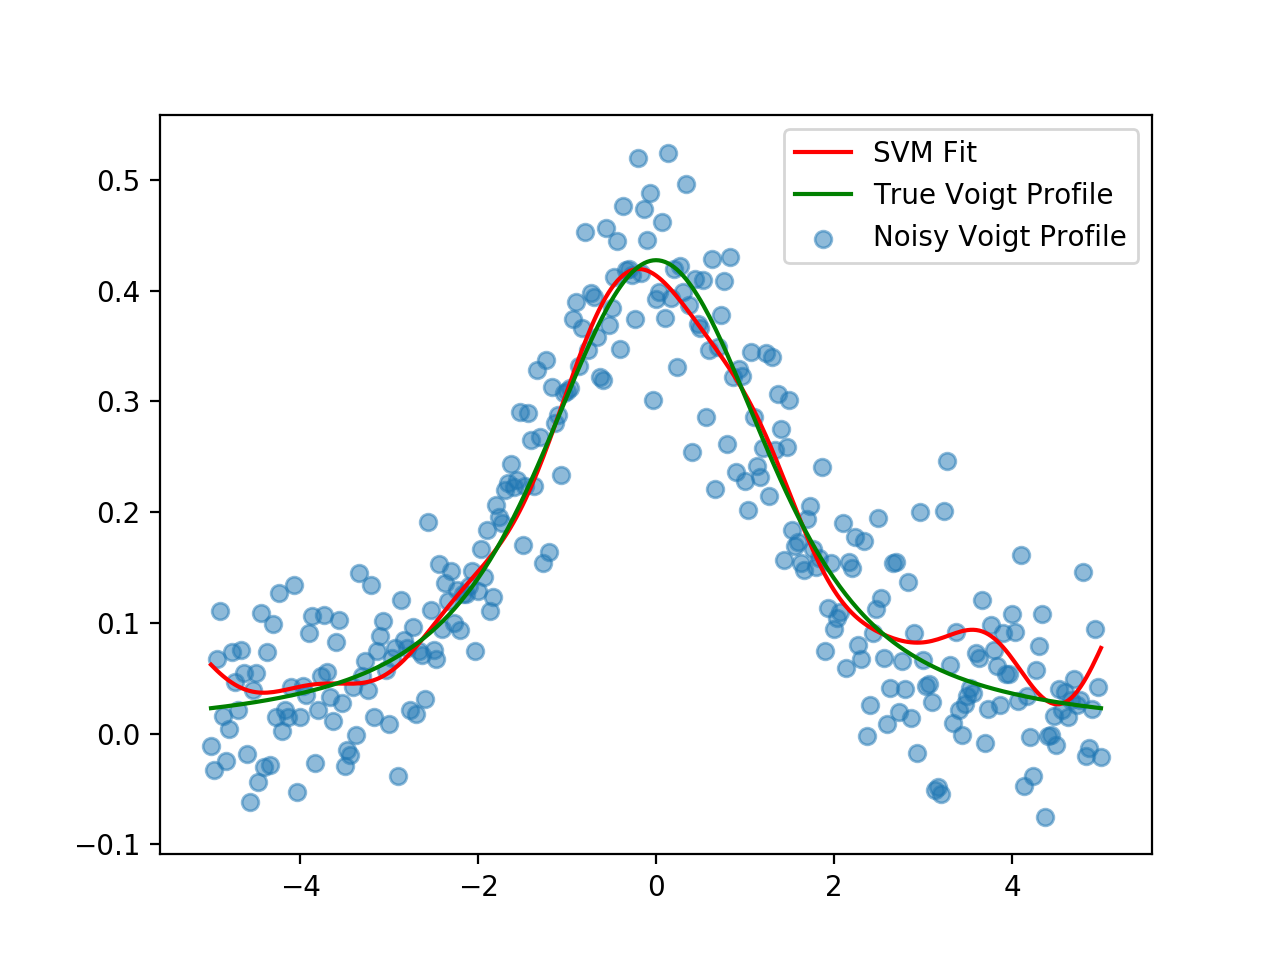

In [26]:
plt.figure()
plt.plot(X,y_rbf,"r",label="SVM Fit")
plt.scatter(X,y,alpha=0.5,label="Noisy Voigt Profile")
plt.plot(X,voigt["true_profile"],"g",label="True Voigt Profile")
plt.legend()

In [27]:
model = nn.Sequential(
    nn.Linear(1,100),
    nn.Sigmoid(),
    nn.Linear(100,1)
)

loss_fn = nn.MSELoss()
optimiser = torch.optim.SGD(model.parameters(),lr=0.01)

In [28]:
xy = np.stack((X,y),axis=1)
xy_train, xy_test = train_test_split(xy,test_size=0.1)
x_train, y_train = xy_train[:,0], xy_train[:,1]
x_test, y_test = xy_test[:,0], xy_test[:,1]

In [29]:
train_loader = DataLoader(TensorDataset(torch.from_numpy(x_train).float(),torch.from_numpy(y_train).float()),shuffle=True)
test_loader = DataLoader(TensorDataset(torch.from_numpy(x_test).float(),torch.from_numpy(y_test).float()))

In [30]:
for t in range(1000):
    for item, ans in train_loader:
        optimiser.zero_grad()

        y_pred = model(item)

        loss = loss_fn(y_pred,ans)

        loss.backward()

        optimiser.step()
    
    for item, ans in test_loader:
        with torch.no_grad():
            y_pred_test = model(item)

            loss_test = loss_fn(y_pred_test,ans)

    print(t, loss_test.item())

0 0.0002439856471028179
1 3.991723133367486e-05
2 0.003814826952293515
3 3.064431803068146e-05
4 0.007301777601242065
5 0.0005885727587155998
6 0.0003408329503145069
7 0.00013623834820464253
8 1.4771713722439017e-05
9 0.014385100454092026
10 0.0018354491330683231
11 0.0013408398954197764
12 0.0068512954749166965
13 0.009988604113459587
14 6.875261169625446e-05
15 0.0028779746498912573
16 5.91029784118291e-05
17 0.007185203954577446
18 0.0010563434334471822
19 0.006981493905186653
20 0.0007982238894328475
21 0.0009788628667593002
22 0.004675033502280712
23 0.008612311445176601
24 0.00047435870510526
25 3.4178822261310415e-07
26 6.7915602812718134e-06
27 3.914244371117093e-05
28 0.0018414229853078723
29 0.003710370510816574
30 0.001516039134003222
31 0.005497609730809927
32 0.0003965836949646473
33 0.0022553009912371635
34 0.0007887309766374528
35 0.0002996452385559678
36 4.332823300501332e-05
37 0.002512049861252308
38 0.0004328307986725122
39 1.5281046216841787e-05
40 0.000865532958414

322 0.002879697596654296
323 0.006071176379919052
324 0.0005081393173895776
325 5.587123723671539e-06
326 5.473812052514404e-05
327 2.8297876269789413e-05
328 0.003803870640695095
329 0.0008157854899764061
330 0.0012885589385405183
331 8.336606697412208e-05
332 0.0005019337986595929
333 3.069329613936134e-05
334 0.0022967595141381025
335 7.460991582775023e-06
336 0.004104163032025099
337 1.0040566849056631e-05
338 0.000620334642007947
339 0.0028629982843995094
340 2.3450083972420543e-06
341 4.283875387045555e-05
342 0.00021278463827911764
343 3.018672201093864e-09
344 5.325479378370801e-06
345 0.00014857188216410577
346 0.005355974193662405
347 0.0019544123206287622
348 0.00153072620742023
349 0.00025733906659297645
350 1.735631303745322e-05
351 0.0004839104076381773
352 0.0001774897100403905
353 0.0014369653072208166
354 0.0009189573465846479
355 0.0006603939109481871
356 7.137561624404043e-05
357 0.0024134451523423195
358 0.0016682542627677321
359 0.002516608452424407
360 5.980396235

643 0.001209741341881454
644 0.0057572415098547935
645 0.0055811405181884766
646 0.00011052258196286857
647 0.0008438043296337128
648 0.0010952707380056381
649 0.008288534358143806
650 0.00030859882826916873
651 4.7214096412062645e-05
652 0.0007644646684639156
653 0.003926897421479225
654 0.0005568360211327672
655 0.003368816338479519
656 0.00045563888852484524
657 6.637825208599679e-06
658 0.0014363372465595603
659 0.0004210677871014923
660 0.00015286770940292627
661 2.1155627109692432e-05
662 0.001539038261398673
663 1.7609354472369887e-06
664 7.569499575765803e-05
665 6.912213734722172e-07
666 0.007313868962228298
667 0.0011172676458954811
668 0.00013531740114558488
669 1.952987258846406e-05
670 0.0014031712198629975
671 2.6647654522093944e-05
672 0.0031839266885071993
673 0.0016729452181607485
674 0.0024740833323448896
675 0.0013171385508030653
676 0.005268052686005831
677 0.008283952251076698
678 0.00022771309886593372
679 0.000199532849364914
680 0.002818220527842641
681 0.000367

963 0.0016840030439198017
964 0.0019498510519042611
965 0.0001935853506438434
966 0.0005909805768169463
967 0.000510169193148613
968 0.00026002185768447816
969 0.0014381003566086292
970 0.001538480632007122
971 0.0029031482990831137
972 0.001226781983859837
973 0.0025333710946142673
974 0.0007576640928164124
975 0.0012070639058947563
976 0.0031336299143731594
977 0.0010076193138957024
978 0.0028101077768951654
979 3.555265357135795e-05
980 0.00030833002529107034
981 0.002944285050034523
982 2.0633440726669505e-05
983 0.0012406239984557033
984 0.003654964966699481
985 0.0008077544043771923
986 0.0017555070808157325
987 0.0019106260733678937
988 0.00028252042829990387
989 0.00015798831009306014
990 0.007654034532606602
991 0.002484387718141079
992 0.001960157649591565
993 7.669223850825801e-05
994 0.0017190434737131
995 0.003955824300646782
996 0.00010725860920501873
997 0.004847789648920298
998 1.3634312381327618e-06
999 0.0011472952319309115


In [31]:
x_test = torch.linspace(-5,5,steps=301)
with torch.no_grad():
    y_test = model(x_test.unsqueeze(1))

<IPython.core.display.Javascript object>


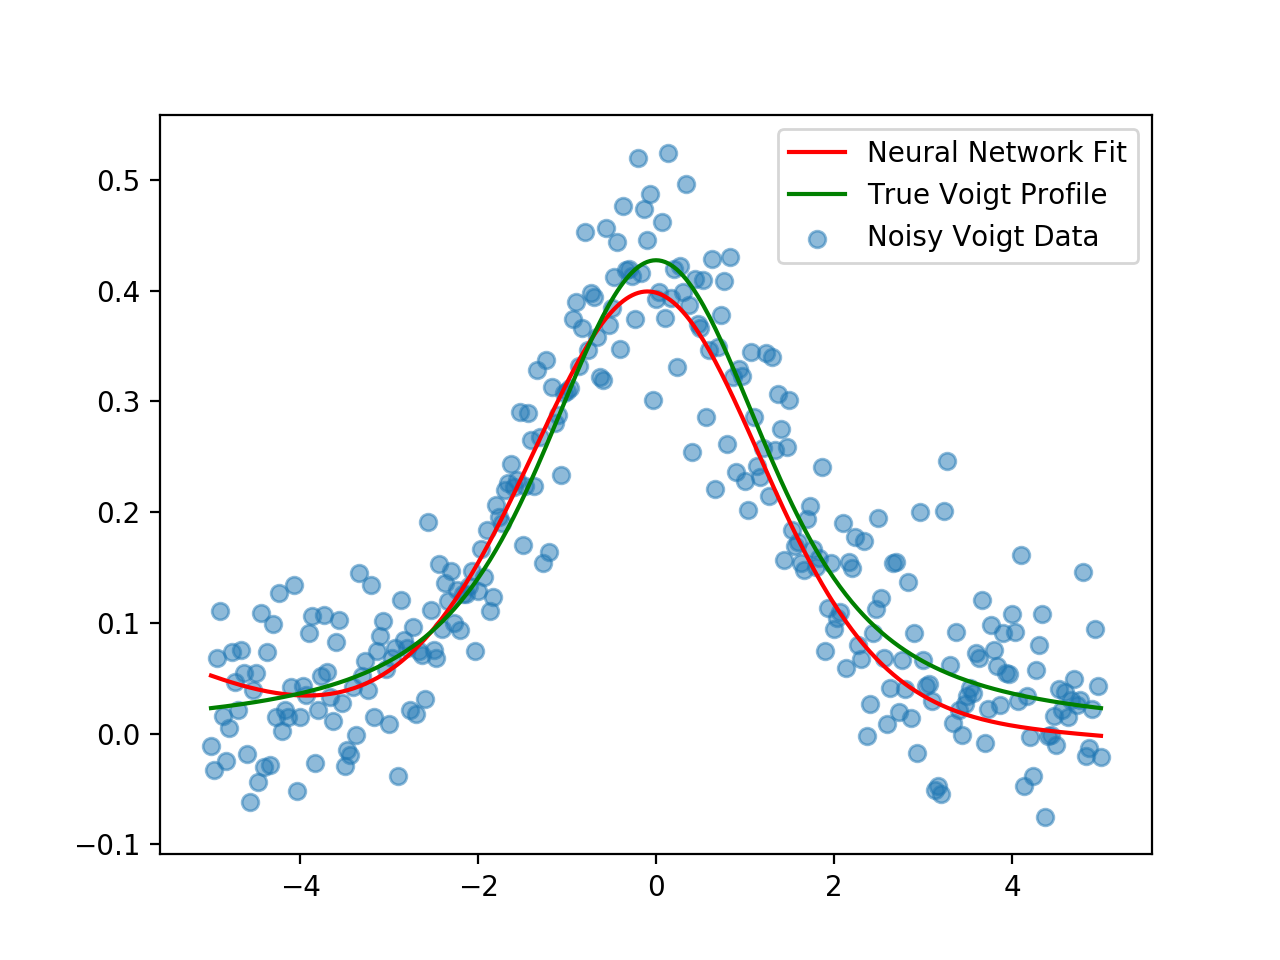

In [33]:
plt.figure()
plt.plot(x_test.detach().numpy(),y_test.detach().numpy(),"r",label="Neural Network Fit")
plt.scatter(X,y,alpha=0.5,label="Noisy Voigt Data")
plt.plot(X,voigt["true_profile"],"g",label="True Voigt Profile")
plt.legend()

## More complex function approximation using NNs

We now generalise our neural network to learn the Voigt profile for arbitrary damping factor, a (where previously we have taken a = 1). Now load in the data containing many Voigt functions. Here we train a shallow neural network to try to learn the general voigt function (the data is already provided in `general_voigt.npz`).

Try training for 500 epochs and see how well you can generate a Voigt profile by creating your own with damping factor 0 $\leq$ a $\leq$ 2. The function for making a Voigt profile is provided below.

In [34]:
def voigt_H(a,v):
    z = v + 1j * a
    return special.wofz(z).real

In [35]:
general_voigt = np.load("general_voigt.npz")

In [37]:
list(general_voigt.keys())

['a_range', 'train_data', 'test_data']

In [38]:
model = nn.Sequential(
    nn.Linear(2,1000),
    nn.Sigmoid(),
    nn.Linear(1000,1)
)

loss_fn = nn.MSELoss()
optimiser = torch.optim.SGD(model.parameters(),lr=0.001)

In [39]:
train_input = np.stack((general_voigt["train_data"][:,:,0].flatten(),general_voigt["train_data"][:,:,1].flatten()),axis=1)
train_output = general_voigt["train_data"][:,:,2].flatten()
test_input = np.stack((general_voigt["test_data"][:,:,0].flatten(),general_voigt["test_data"][:,:,1].flatten()),axis=1)
test_output = general_voigt["test_data"][:,:,2].flatten()

In [40]:
train_loader = DataLoader(TensorDataset(torch.from_numpy(train_input),torch.from_numpy(train_output)),shuffle=True)
test_loader = DataLoader(TensorDataset(torch.from_numpy(test_input),torch.from_numpy(test_output)))

In [41]:
for t in range(500):
    loss_list = []
    for item, ans in train_loader:
        item, ans = item.float(), ans.float()
        
        optimiser.zero_grad()

        y_pred = model(item)

        loss = loss_fn(y_pred,ans)

        loss.backward()

        optimiser.step()
    
    for item, ans in test_loader:
        with torch.no_grad():
            item, ans = item.float(), ans.float()
            y_pred_test = model(item)

            loss_test = loss_fn(y_pred_test,ans)

            loss_list.append(loss_test.item())
    print(t, np.mean(loss_list))

0 0.007991602774280826
1 0.011504509455651783
2 0.006731469035185182
3 0.005730712216120673
4 0.007402642835090028
5 0.005548853344203837
6 0.005455459205476363
7 0.009150741012686347
8 0.00525518723559741
9 0.011451206999354032
10 0.005421570477186142
11 0.005115393127628059
12 0.004949797586938755
13 0.006033782248664975
14 0.0053420956366208696
15 0.004567550953565458
16 0.00860374050878797
17 0.003960659152464079
18 0.010153991403909993
19 0.007090790419825558
20 0.005295643058750179
21 0.010840054280181359
22 0.0038555969775195854
23 0.004287680289589361
24 0.0075530122538316835
25 0.00445879123131338
26 0.003596897332146528
27 0.003338120436842753
28 0.0033454804602935156
29 0.003385955191405561
30 0.006026093595328711
31 0.0059595684537144325
32 0.003328573180336809
33 0.009842098793914152
34 0.003834543570102655
35 0.006195967585025664
36 0.004088776956064911
37 0.003418190060317197
38 0.0030676264717409718
39 0.0039556825862488544
40 0.003611511170718274
41 0.00379981406456434

325 0.0012267119394509362
326 0.0008056452569723895
327 0.0009597867140530312
328 0.0009110889193771267
329 0.0006208789400399094
330 0.019136375063302978
331 0.000588773195947456
332 0.0007510645524231465
333 0.0009353024246646391
334 0.0006167047265710784
335 0.0006263777690109047
336 0.0009617456764984568
337 0.0010423101868647553
338 0.0007197426793554946
339 0.0006147605975316381
340 0.0010340637290645852
341 0.0013060941458649371
342 0.0006888414881347556
343 0.0006388034540998344
344 0.000697003256640335
345 0.0009185083007218779
346 0.0005648860289273779
347 0.0005618338548267489
348 0.0006211508150204539
349 0.0006999085027781638
350 0.0006566089483635153
351 0.0015291884178928832
352 0.000997593492184708
353 0.0005975866533436632
354 0.0006130825951587668
355 0.0007453698525474007
356 0.0006060299888718287
357 0.0005366839738534655
358 0.000627548110271955
359 0.0005516797799427974
360 0.0006217171823825338
361 0.0006832524394771031
362 0.000536635107925879
363 0.000524018427

In [42]:
v_range = np.linspace(-5,5,num=51)
a_vec = np.empty_like(v_range)
a_vec.fill(0)
x_test = np.stack((a_vec,v_range),axis=1)

In [43]:
x_test_tensor = torch.from_numpy(x_test).float()
with torch.no_grad():
    y_test_tensor = model(x_test_tensor)

In [44]:
real_profile = voigt_H(0,v_range)

<IPython.core.display.Javascript object>


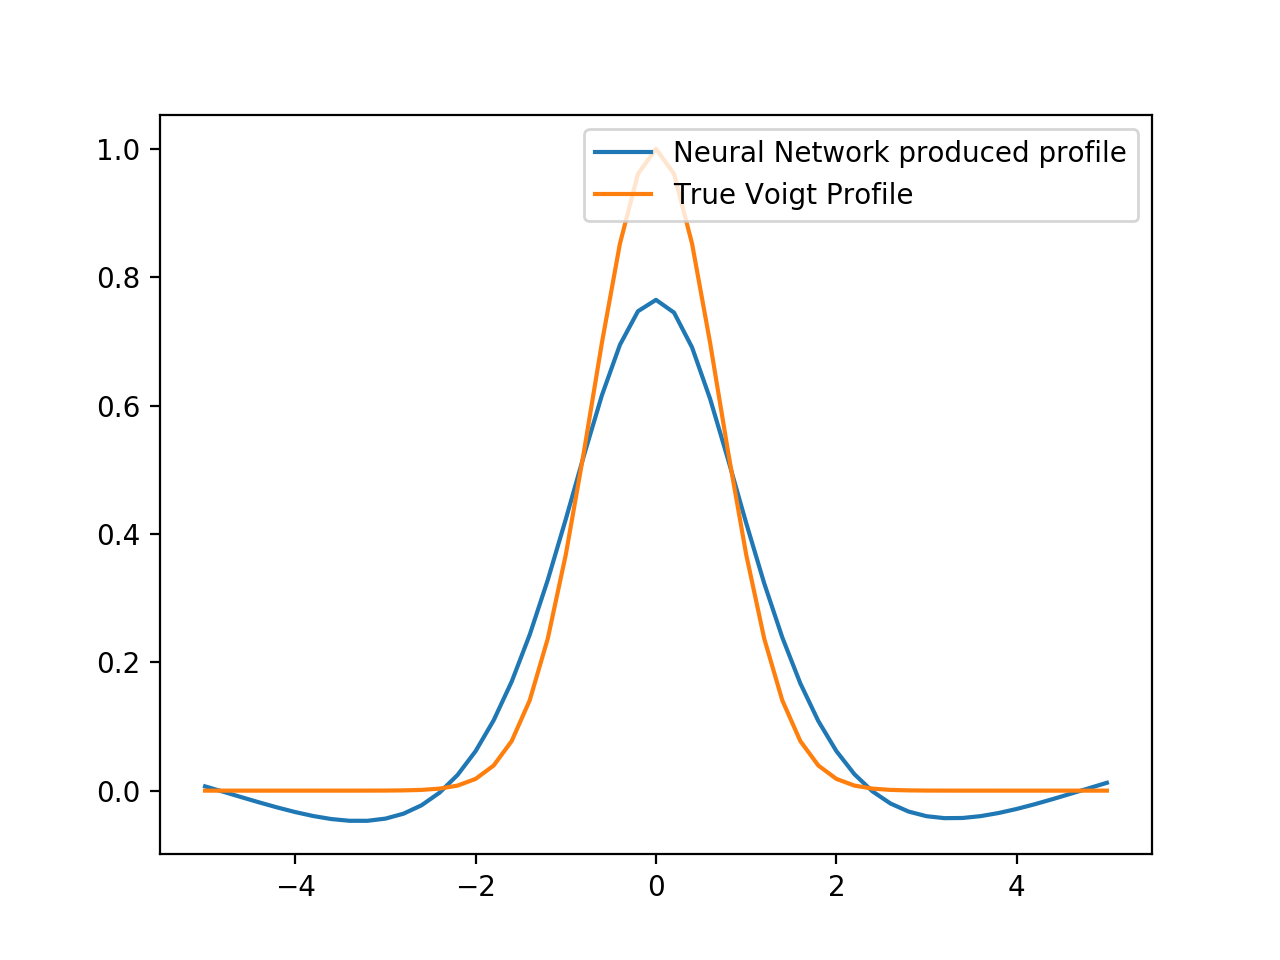

In [46]:
plt.figure()
plt.plot(v_range,y_test_tensor.numpy(),label="Neural Network produced profile")
plt.plot(v_range,real_profile,label="True Voigt Profile")
plt.legend()